In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [ ]:
def ReLU(z : np.ndarray):
    z[z < 0] = 0
    return z

def softmax(z : np.ndarray):
    max_vals = z.max(axis = -1, keepdims = True)
    z_ = z - max_vals
    exp_z_ = np.exp(z_)
    return exp_z_ / exp_z_.sum(axis = -1, keepdims = True)

In [ ]:
class Model:
    def __init__(self, input_dim : int, layers : list) -> None:
        super().__init__()
        self.weights = [np.random.normal(size = [input_dim, layers[0]])]
        self.bias = [np.random.normal(size = [1, layers[0]])]
        self.z = []
        self.a = []

        self.dW = [None] * len(self.weights)
        self.dB = [None] * len(self.bias)
        self.dA = [None] * len(self.a)
        self.dZ = [None] * len(self.z)

        for i in range(1, len(layers)):
            self.weights += [np.random.normal(size = [layers[i - 1], layers[i]])]
            self.bias += [np.random.normal(size = [1, layers[i]])]

    def forward(self, input_tensor):
        self.z = []
        self.a = []

        x = input_tensor
        for i in range(len(self.weights)):
            x = x.dot(self.weights[i]) + self.bias[i]
            self.z.append(np.copy(x))

            if i != len(self.weights) - 1:
                x = ReLU(x)
            else:
                x = softmax(x)

            self.a.append(np.copy(x))

        return x


    def loss(self, predicted, actual):
        # predicted_shape = [m, layers[-1]]
        # actual_shape = [m, 1]
        epsilon = 1e-12
        predicted = np.clip(predicted, a_min = epsilon, a_max = 1 - epsilon)
        corresponding_probs = predicted[np.arange(actual.shape[0]), actual.flatten()]
        return -1* np.log(corresponding_probs).mean()

    def backward(self, input_tensor, predicted, actual, learning_rate):
        # initial assigment
        self.dW = [None] * len(self.weights)
        self.dB = [None] * len(self.bias)
        self.dA = [None] * len(self.a)
        self.dZ = [None] * len(self.z)


        # predicted_shape = [m, layers[-1]]
        # actual_shape = [m, 1]

        # for last layer
        actual_one_hot = np.zeros_like(predicted)
        actual_one_hot[np.arange(predicted.shape[0]), actual.reshape(-1, )] = 1

        dL_by_dZ = (predicted - actual_one_hot) / predicted.shape[0]
        prev_activation = self.a[-2] if len(self.a) >= 2 else input_tensor
        dL_by_dW = prev_activation.T.dot(dL_by_dZ)
        dL_by_dB = dL_by_dZ.mean(axis = 0, keepdims = True)
        dL_by_dA_prev = dL_by_dZ.dot(self.weights[-1].T)

        self.dW[-1] = dL_by_dW
        self.dB[-1] = dL_by_dB
        self.dA[-1] = None # as last layer, so directly calculating dZ
        self.dZ[-1] = dL_by_dZ

        if len(self.dA) >= 2:
            self.dA[-2] = dL_by_dA_prev

        for layer_idx in range(len(self.weights) - 2, 0, -1):
            dA_k_by_dZ_k = (self.z[layer_idx] > 0).astype(np.float32)

            dL_by_dZ_k = self.dA[layer_idx] * dA_k_by_dZ_k
            prev_activation = self.a[layer_idx - 1] if layer_idx - 1 >= 0 else input_tensor
            dL_by_dW_k = prev_activation.T.dot(dL_by_dZ_k)
            dL_by_dB_k = dL_by_dZ_k.mean(axis = 0, keepdims = True)
            dL_by_dA_k_prev = dL_by_dZ_k.dot(self.weights[layer_idx].T)

            self.dW[layer_idx] = dL_by_dW_k
            self.dB[layer_idx] = dL_by_dB_k
            self.dZ[layer_idx] = dL_by_dZ_k
            if layer_idx - 1 >= 0:
                self.dA[layer_idx - 1] = dL_by_dA_k_prev


        dL_by_dZ_0 = self.dA[0] * ((self.z[0] > 0).astype(np.float32))
        dL_by_dW_0 = input_tensor.T.dot(dL_by_dZ_0)
        dL_by_dB_0 = dL_by_dZ_0.mean(axis = 0, keepdims = True)

        self.dZ[0] = dL_by_dZ_0
        self.dW[0] = dL_by_dW_0
        self.dB[0] = dL_by_dB_0


        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * self.dW[i]
            self.bias[i] -= learning_rate * self.dB[i]

    def accuracy(self, predicted, actual):
        # predicted : [m, num_classes]
        # actual : [m, 1]
        predicted_classes = predicted.argmax(axis = -1)
        return (predicted_classes == actual.reshape(-1, )).sum() / actual.shape[0]

(10, 2)
0.9174724864662988


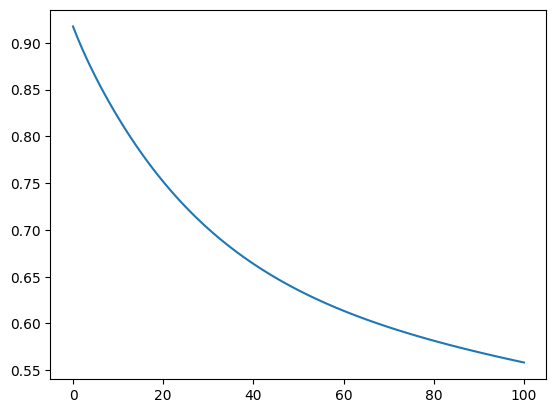

0.7

In [ ]:
np.random.seed(123)

layers = [2, 2]
model = Model(input_dim = 4, layers = layers)
x = np.random.normal(size = [10, 4])
y = np.random.randint(low = 0, high = layers[-1], size = [10, 1])

y_pred = model.forward(x)
print(y_pred.shape)
print(model.loss(y_pred, y))
losses = [model.loss(y_pred, y)]

for i in range(100):
    model.backward(x, y_pred, y, 0.05)
    y_pred = model.forward(x)
    losses.append(model.loss(y_pred, y))

plt.plot(losses)
plt.show()

y_pred = model.forward(x)
model.accuracy(y_pred, y)

In [ ]:
np.random.seed(123)

iris_ds = load_iris()
X = iris_ds["data"]
y = iris_ds["target"].reshape(-1, 1)
target_names = iris_ds["target_names"]
num_classes = len(target_names)

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

num_epochs = 10000
train_losses = []
test_losses = []
train_accs = []
test_accs = []

layers = [2, num_classes]
model = Model(input_dim = X.shape[1], layers = layers)

y_train_pred = model.forward(X_train)
y_test_pred = model.forward(X_test)

train_losses.append(model.loss(y_train_pred, y_train))
test_losses.append(model.loss(y_test_pred, y_test))
train_accs.append(model.accuracy(y_train_pred, y_train))
test_accs.append(model.accuracy(y_test_pred, y_test))

for i in range(num_epochs):
    y_train_pred = model.forward(X_train)
    model.backward(X_train, y_train_pred, y_train, learning_rate = 0.02)

    y_train_pred = model.forward(X_train)
    y_test_pred = model.forward(X_test)

    train_losses.append(model.loss(y_train_pred, y_train))
    test_losses.append(model.loss(y_test_pred, y_test))

    train_accs.append(model.accuracy(y_train_pred, y_train))
    test_accs.append(model.accuracy(y_test_pred, y_test))

(150, 4) (150, 1)
(120, 4) (30, 4) (120, 1) (30, 1)


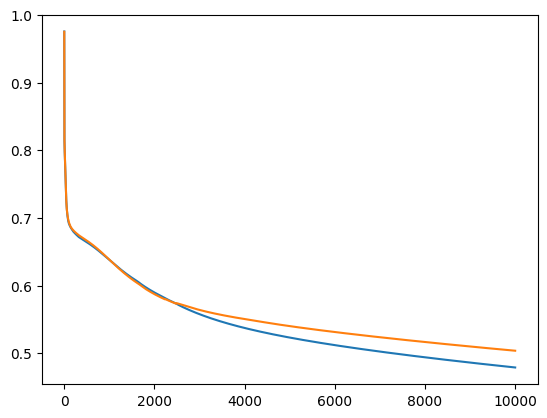

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)

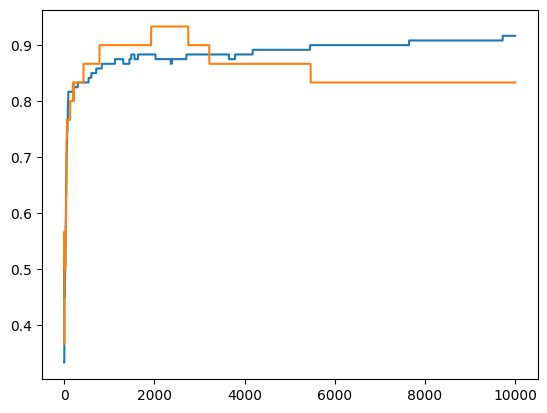

In [ ]:
plt.plot(train_accs)
plt.plot(test_accs)

In [ ]:
train_accs[-1], test_accs[-1]

(0.9166666666666666, 0.8333333333333334)